In [287]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from scipy.stats import mannwhitneyu
from pathlib import Path

In [288]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

In [289]:
base_path = Path("simulation_results_workstation_physicserrorcsteps_newincrv2/simulation_results")
all_folders = base_path.glob("*pts*")

# Now in each folder for each pkl file open the observation list
# From the observation list get obs_list[-1]["fly"][0] the last fly position
# Generate a scatter plot for each condition with the last fly z position¨
# Chnage the color if the adhesion is on
# Save the figure in the base directory

save_path = base_path / "panel_adh.pdf"

controllers = ["cpg", "rule_based", "hybrid"]
terrain = ["flat", "blocks", "gapped", "mixed"]
adhesion = [True]

conditions = [(c, t) for t in terrain for c in controllers]
n_conditions = len(conditions)

#sim_time = 1.0
#init_time = 0.0
timestep = 1e-4
all_rows = []
all_colors = np.tile(["r", "b"], n_conditions)


start_pts = 0
all_dir = True

for controller, terrain in conditions:
    for adh in adhesion:
        path = base_path / f"{terrain}/{controller}"
        if not path.is_dir():
            print(f"Path {path} does not exist")
            continue
        all_pkl = list(path.glob("*.pkl"))
        assert len(all_pkl) > 1, f"Path {path} does not contain any pkl file"
        data_pts = []
        for pkl_file in all_pkl:
            with open(pkl_file, "rb") as f:
                try:
                    obs_list = pickle.load(f)
                except:
                    obs_list = []
            #assert len(obs_list) == sim_time * 10_000    
            if len(obs_list) > start_pts:
                if all_dir:
                    distance = np.linalg.norm(obs_list[-1]["fly"][0][:2] - obs_list[start_pts]["fly"][0][:2])
                else:
                    distance = obs_list[-1]["fly"][0][0] - obs_list[start_pts]["fly"][0][0]
                exp_len = (len(obs_list) - start_pts) * timestep
            else:
                distance = 0.0
                exp_len = 100
            speed = distance / exp_len
            all_rows.append([controller.lower(), terrain.lower(), adh, speed, distance])

speed_df = pd.DataFrame(
    all_rows, columns=["controller", "terrain", "adhesion", "speed", "distance"]
)
#speed_df.to_csv("outputs/mean_speed.csv", index=False)

In [290]:
# replace rule based with decentralized
speed_df["controller"].replace({"rule_based": "decentralized"}, inplace=True)
controllers[1] = "decentralized"

/var/folders/g_/c0_j6ct50dz58057rf7b3_s00000gq/T/ipykernel_84585/4272763772.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  speed_df["controller"].replace({"rule_based": "decentralized"}, inplace=True)


In [291]:
speed_df_norm = speed_df.copy()
for controller in controllers:
    full_speed = np.nanmean(speed_df[(speed_df["controller"] == controller) & (speed_df["terrain"] == "flat")]["speed"])
    print(full_speed)
    speed_df_norm.loc[speed_df_norm["controller"] == controller, "speed"] /= full_speed

14.427794456481934
10.571103700002034
14.50725402832031


In [292]:
#speed_df.iloc[speed_df["speed"].argmax()] = np.nan

In [293]:
print(
    speed_df[speed_df["terrain"] == "flat"]["speed"].min(),
    speed_df[speed_df["terrain"] == "flat"]["speed"].max(),
)
print(
    speed_df_norm[speed_df_norm["terrain"] != "flat"]["speed"].min(),
    speed_df_norm[speed_df_norm["terrain"] != "flat"]["speed"].max(),
)

10.010802586873373 14.84048334757487
0.053320653408853676 1.0219785627074889


/var/folders/g_/c0_j6ct50dz58057rf7b3_s00000gq/T/ipykernel_84585/197289108.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/Users/stimpfli/anaconda3/envs/data_analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/stimpfli/anaconda3/envs/data_analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/stimpfli/anaconda3/envs/data_analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  w

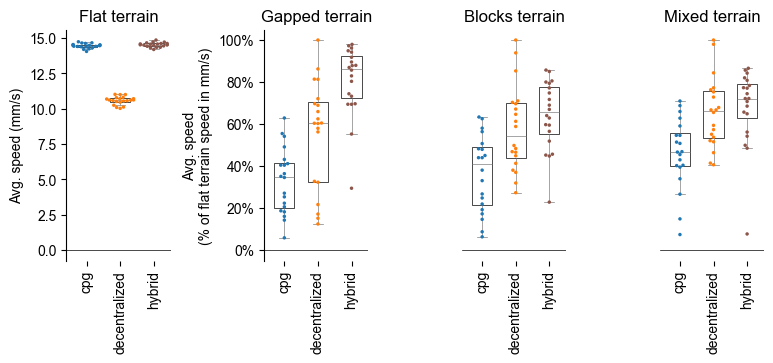

In [308]:

x_pos_lookup = {
    ("cpg", "flat"): 0,
    ("decentralized", "flat"): 1,
    ("hybrid", "flat"): 2,
    ("cpg", "gapped"): 5,
    ("decentralized", "gapped"): 6,
    ("hybrid", "gapped"): 7,
    ("cpg", "blocks"): 10,
    ("decentralized", "blocks"): 11,
    ("hybrid", "blocks"): 12,
    ("cpg", "mixed"): 15,
    ("decentralized", "mixed"): 16,
    ("hybrid", "mixed"): 17,
}
colors_lookup = {
    "cpg": "tab:blue",
    "decentralized": "tab:orange",
    "hybrid": "tab:brown",
}

fig, axs = plt.subplots(1, 4, figsize=(9, 3))
plt.subplots_adjust(wspace=0.9)
for i, terrain_type in enumerate(["flat", "gapped", "blocks", "mixed"]):
    ax = axs[i]
    ax.set_title(f"{terrain_type.title()} terrain")

    df = speed_df if terrain_type == "flat" else speed_df_norm
    ylim = [-0.15 * 10 / 1.15, 25] if terrain_type == "flat" else [-0.15, 1.15]

    boxplot = sns.boxplot(
        x="controller",
        y="speed",
        data=df.query(f"terrain == '{terrain_type}'"),
        width=0.6,
        ax=ax,
        showfliers=False,
        boxprops={"facecolor": "None", "edgecolor": "k", "linewidth": 0.5},
        medianprops={"color": "gray", "linewidth": 0.5},
        whiskerprops={"color": "gray", "linewidth": 0.5},
        capprops={"color": "gray", "linewidth": 0.5},
    )
    sns.swarmplot(
        x="controller",
        y="speed",
        data=df.query(f"terrain == '{terrain_type}'"),
        hue="controller",
        size=2.5,
        palette=["tab:blue", "tab:orange", "tab:brown"],
        ax=ax,
        legend=False,
    )
    ax.set_xlim(-0.6, 2.5)
    #ax.set_ylim(ylim)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.axhline(0.0, color="k", linewidth=0.5)
    if terrain_type not in ["flat", "gapped"]:
        ax.set_ylabel("")
        ax.set_yticks([])
        pass
    if terrain_type == "flat":
        ax.set_ylabel("Avg. speed (mm/s)")
    elif terrain_type == "gapped":
        ax.set_ylabel("Avg. speed\n(% of flat terrain speed in mm/s)")
        ax.yaxis.set_major_formatter(mticker.PercentFormatter(1))
    ax.set_xlabel("")
    sns.despine(ax=ax, bottom=True, left=terrain_type not in ["flat", "gapped"])

"""for i, terrain in enumerate(["flat", "gapped", "blocks", "mixed"]):
    ax = axs[i]
    N = df.query(f"terrain == '{terrain}'").groupby("controller")["speed"].apply(lambda x: np.sum(pd.notna(x)))
    x_axis_label = [f"{controller} (N={n})" for cont in controllers for controller, n in zip(N.index.values, N.values) if cont == controller]
    ax.set_xticks(range(3), x_axis_label, rotation=90)"""

#plt.savefig("outputs/speed_comparison.pdf", transparent=True)
plt.savefig("outputs/relspeed_comparison_2ddist_0stabilization.pdf", transparent=True, bbox_inches='tight')

/var/folders/g_/c0_j6ct50dz58057rf7b3_s00000gq/T/ipykernel_84585/1025003655.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/Users/stimpfli/anaconda3/envs/data_analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/stimpfli/anaconda3/envs/data_analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/stimpfli/anaconda3/envs/data_analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  

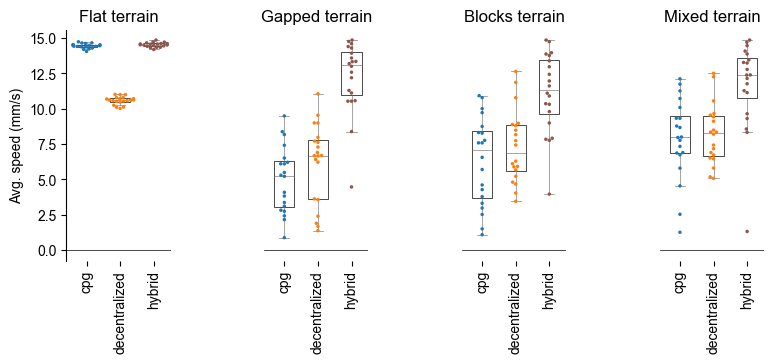

In [309]:

x_pos_lookup = {
    ("cpg", "flat"): 0,
    ("decentralized", "flat"): 1,
    ("hybrid", "flat"): 2,
    ("cpg", "gapped"): 5,
    ("decentralized", "gapped"): 6,
    ("hybrid", "gapped"): 7,
    ("cpg", "blocks"): 10,
    ("decentralized", "blocks"): 11,
    ("hybrid", "blocks"): 12,
    ("cpg", "mixed"): 15,
    ("decentralized", "mixed"): 16,
    ("hybrid", "mixed"): 17,
}
colors_lookup = {
    "cpg": "tab:blue",
    "decentralized": "tab:orange",
    "hybrid": "tab:brown",
}

fig, axs = plt.subplots(1, 4, figsize=(9, 3))
plt.subplots_adjust(wspace=0.9)
for i, terrain_type in enumerate(["flat", "gapped", "blocks", "mixed"]):
    ax = axs[i]
    ax.set_title(f"{terrain_type.title()} terrain")

    df = speed_df
    ylim = [-0.15 * 10 / 1.15, 25]

    boxplot = sns.boxplot(
        x="controller",
        y="speed",
        data=df.query(f"terrain == '{terrain_type}'"),
        width=0.6,
        ax=ax,
        showfliers=False,
        boxprops={"facecolor": "None", "edgecolor": "k", "linewidth": 0.5},
        medianprops={"color": "gray", "linewidth": 0.5},
        whiskerprops={"color": "gray", "linewidth": 0.5},
        capprops={"color": "gray", "linewidth": 0.5},
    )
    sns.swarmplot(
        x="controller",
        y="speed",
        data=df.query(f"terrain == '{terrain_type}'"),
        hue="controller",
        size=2.5,
        palette=["tab:blue", "tab:orange", "tab:brown"],
        ax=ax,
        legend=False,
    )
    ax.set_xlim(-0.6, 2.5)
    #ax.set_ylim(ylim)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.axhline(0.0, color="k", linewidth=0.5)
    if terrain_type not in ["flat"]:
        ax.set_ylabel("")
        ax.set_yticks([])
        pass
    if terrain_type == "flat":
        ax.set_ylabel("Avg. speed (mm/s)")
    ax.set_xlabel("")
    sns.despine(ax=ax, bottom=True, left=terrain_type not in ["flat"])

"""for i, terrain in enumerate(["flat", "gapped", "blocks", "mixed"]):
    ax = axs[i]
    N = df.query(f"terrain == '{terrain}'").groupby("controller")["speed"].apply(lambda x: np.sum(pd.notna(x)))
    x_axis_label = [f"{controller} (N={n})" for cont in controllers for controller, n in zip(N.index.values, N.values) if cont == controller]
    ax.set_xticks(range(3), x_axis_label, rotation=90)"""

#plt.savefig("outputs/speed_comparison.pdf", transparent=True)
plt.savefig("outputs/speed_comparison_2ddist_0stabilization.pdf", transparent=True, bbox_inches='tight')

In [295]:
# remove nans 
speed_df = speed_df.dropna()
speed_df_norm = speed_df_norm.dropna()

In [296]:
for variable, df in [("Absolute speed", speed_df), ("Normalized speed", speed_df_norm)]:
    for terrain_type in ["flat", "gapped", "blocks", "mixed"]:
        hybrid_pts = df[
            (df["controller"] == "hybrid") & (df["terrain"] == terrain_type)
        ]["speed"].values
        for controller in ["cpg", "decentralized"]:
            my_pts = df[
                (df["controller"] == controller) & (df["terrain"] == terrain_type)
            ]["speed"].values
            u, p = mannwhitneyu(
                my_pts, hybrid_pts, alternative="less", method="asymptotic"
            )
            print(f"{variable} - {terrain_type} - {controller} vs hybrid: {p:.6f}")

Absolute speed - flat - cpg vs hybrid: 0.066642
Absolute speed - flat - decentralized vs hybrid: 0.000000
Absolute speed - gapped - cpg vs hybrid: 0.000000
Absolute speed - gapped - decentralized vs hybrid: 0.000001
Absolute speed - blocks - cpg vs hybrid: 0.000019
Absolute speed - blocks - decentralized vs hybrid: 0.000111
Absolute speed - mixed - cpg vs hybrid: 0.000046
Absolute speed - mixed - decentralized vs hybrid: 0.000058
Normalized speed - flat - cpg vs hybrid: 0.526958
Normalized speed - flat - decentralized vs hybrid: 0.652554
Normalized speed - gapped - cpg vs hybrid: 0.000000
Normalized speed - gapped - decentralized vs hybrid: 0.000343
Normalized speed - blocks - cpg vs hybrid: 0.000021
Normalized speed - blocks - decentralized vs hybrid: 0.104227
Normalized speed - mixed - cpg vs hybrid: 0.000065
Normalized speed - mixed - decentralized vs hybrid: 0.136643
